In [1]:
import os
import pickle
import time
import numpy as np
import pandas as pd
import warnings

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
import seaborn as sns

from sklearn.utils import class_weight
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, recall_score, classification_report
from sklearn.metrics import precision_recall_fscore_support as score

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, LSTM, Bidirectional
from tensorflow.keras.optimizers import SGD, Adam

from avaml.aggregatedata import ForecastDataset, LabeledData, REG_ENG, CsvMissingError
from utils.preprocess import *
from utils.feature_engineering import *
from utils.nn import *
from utils.plot_nn_training import *

In [2]:
print(tf.__version__)

# we need to set up gpus for tensorflow-gpu and cudnn
gpus = tf.config.experimental.list_physical_devices(device_type='GPU')
print(gpus)

tf.config.experimental.set_memory_growth(device=gpus[0], enable=True)

2.2.0
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
seed = 42
np.random.seed(seed)
tf.random.set_seed(seed)
warnings.filterwarnings("ignore")

# Download, read in, preprocess data

## Loading data

In [4]:
model_prefix = ''
days = 7
regobs_types = list(REG_ENG.keys())
labeled_data = None
try:
    print("Reading csv")
    labeled_data = LabeledData.from_csv(days=days, regobs_types=regobs_types, with_varsom=True)
except CsvMissingError:
    print("Csv missing. Fetching online data. (This takes a long time.)")
    labeled_data = ForecastDataset(regobs_types=regobs_types).label(days=days, with_varsom=True)
    labeled_data.to_csv()

Reading csv


In [5]:
# read in data, extract data and labels
labeled_data = preprocess(labeled_data)
regions = labeled_data.data.reorder_levels([1, 0])
labels = labeled_data.label.reorder_levels([1, 0])

In [6]:
regions

,,danger_level_1,danger_level_2,danger_level_3,danger_level_4,danger_level_5,danger_level_6,emergency_warning_1,emergency_warning_2,emergency_warning_3,emergency_warning_4,...,regobs_snowprofile_t_min_4_4,regobs_snowprofile_t_min_4_5,regobs_snowprofile_t_min_4_6,regobs_snowprofile_t_min_4_7,accuracy_2,accuracy_3,accuracy_4,accuracy_5,accuracy_6,accuracy_7
region,date,,,,,,,,,,,,,,,,,,,,,
3003,2017-12-07,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3007,2017-12-07,3.0,2.0,3.0,2.0,2.0,2.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3009,2017-12-07,3.0,2.0,2.0,2.0,2.0,2.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3010,2017-12-07,3.0,3.0,3.0,2.0,2.0,2.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3011,2017-12-07,3.0,3.0,3.0,2.0,2.0,2.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3031,2021-01-12,3.0,3.0,3.0,2.0,2.0,2.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3032,2021-01-12,3.0,3.0,3.0,2.0,2.0,2.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3034,2021-01-12,3.0,3.0,3.0,2.0,2.0,2.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


One of the first things we need to take care of is the precipitation column. There are some extremely high values throughout the dataset that we need to drop.

In [7]:
precip_cols = [col for col in regions.columns if 'precip' in col and 'exposed' not in col]
regions_precip = regions.loc[:, precip_cols]

There is a set of anomalously high precipitation values in this dataset that we need to be mindful of.

In [8]:
precip_outliers = np.where(regions_precip > 100)[0]

In [9]:
drop_idx = regions.index[precip_outliers]
regions = regions.drop(drop_idx)

In [10]:
regions.loc[:, precip_cols].max()

precip_0    95.6
precip_1    95.6
precip_2    95.6
precip_3    95.6
precip_4    95.6
precip_5    95.6
dtype: float64

These seem like more reasonable values. We need to do the same thing for the labels, though.

In [11]:
labels = labels.drop(drop_idx)

In [12]:
print('Shape of input data:  {}'.format(regions.shape))
print('Shape of labels    :  {}'.format(labels.shape))

Shape of input data:  (12519, 6516)
Shape of labels    :  (12519, 69)


In [13]:
# encode cause and aspect columns in labels
labels = encode_causes(labels)
labels = encode_aspects(labels)

## Feature Engineering

In a previous Notebook analysis on the importance of different features, we say that different meteorological variables from RegObs are often more important than other fields included in the data. And what's more, combining variables to create custom features is even *more* important. We can create those features again below.

In [14]:
# drop wind speed columns
wind_dir_cols = [col for col in regions.columns if 'wind_dir' in col]
#regions.drop(wind_dir_cols, axis=1, inplace=True)

# create 72 hour sum or max of wind speed, precip, and max temp
wind_speed_cols = [col for col in regions.columns if 'wind' in col and 'speed' in col]
regions = wind_speed_max(regions, wind_speed_cols)
to_sum = ['wind_speed_max_0', 'wind_speed_max_1', 'wind_speed_max_2']
regions = sum_over_features(regions, to_sum, 'wind_speed_72hr')

to_sum = ['precip_0', 'precip_1', 'precip_2']
regions = sum_over_features(regions, to_sum, 'precip_72hr')

to_sum = ['temp_max_0', 'temp_max_1', 'temp_max_2']
regions = take_max(regions, to_sum, 'temp_max_72hr')

In [15]:
# below, think about also removing emergency warning and any columns with the word "problem" in it
dont_include_list = ['acc', 'dir', 'fl_start', 'regobs', 'start']
to_include = [col for col in regions.columns]

for drop_col in dont_include_list:
    to_include = [col for col in to_include if drop_col not in col]

train = regions.loc[:, to_include]
train

,,danger_level_1,danger_level_2,danger_level_3,danger_level_4,danger_level_5,danger_level_6,emergency_warning_1,emergency_warning_2,emergency_warning_3,emergency_warning_4,...,temp_freeze_lev_5,wind_speed_max_0,wind_speed_max_1,wind_speed_max_2,wind_speed_max_3,wind_speed_max_4,wind_speed_max_5,wind_speed_72hr,precip_72hr,temp_max_72hr
region,date,,,,,,,,,,,,,,,,,,,,,
3003,2017-12-07,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.000,15.5,9.0,9.0,0.0,9.0,9.0,33.5,1.0,-8.0
3007,2017-12-07,3.0,2.0,3.0,2.0,2.0,2.0,1.0,1.0,1.0,1.0,...,237.510,12.0,9.0,5.5,9.0,9.0,12.0,26.5,7.6,-5.9
3009,2017-12-07,3.0,2.0,2.0,2.0,2.0,2.0,1.0,1.0,1.0,1.0,...,267.920,15.5,5.5,9.0,9.0,9.0,9.0,30.0,15.7,-6.5
3010,2017-12-07,3.0,3.0,3.0,2.0,2.0,2.0,1.0,1.0,1.0,1.0,...,326.270,15.5,5.5,12.0,12.0,9.0,9.0,33.0,21.5,-6.2
3011,2017-12-07,3.0,3.0,3.0,2.0,2.0,2.0,1.0,1.0,1.0,1.0,...,210.565,12.0,5.5,5.5,9.0,9.0,9.0,23.0,24.1,-2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3031,2021-01-12,3.0,3.0,3.0,2.0,2.0,2.0,1.0,1.0,1.0,1.0,...,0.000,9.0,5.5,5.5,15.5,0.0,0.0,20.0,15.0,-5.0
3032,2021-01-12,3.0,3.0,3.0,2.0,2.0,2.0,1.0,1.0,1.0,1.0,...,0.000,12.0,5.5,9.0,12.0,0.0,0.0,26.5,3.0,-9.0
3034,2021-01-12,3.0,3.0,3.0,2.0,2.0,2.0,1.0,1.0,1.0,1.0,...,0.000,9.0,5.5,9.0,12.0,5.5,5.5,23.5,16.0,-7.0


### How many danger level 4's are in each region?

In [16]:
train_idx = [3007, 3012, 3010, 3009, 3013, 3017, 3014, 3032, 
             3027, 3029, 3022, 3031, 3023, 3037, 3024, 3028]
val_idx =   [3011, 3016, 3035]
test_idx =  [3006, 3015, 3034]

print("\nTraining set:")
for idx in train_idx:
    temp_df = labels.loc[idx]
    where_dl4 = len(np.where(temp_df['CLASS_danger_level'] == 4)[0])
    print("Region {} has {} danger level 4's.".format(idx, where_dl4))
    
print("\nValidation set:")
for idx in val_idx:
    temp_df = labels.loc[idx]
    where_dl4 = len(np.where(temp_df['CLASS_danger_level'] == 4)[0])
    print("Region {} has {} danger level 4's.".format(idx, where_dl4))
    
print("\nTesting set:")
for idx in test_idx:
    temp_df = labels.loc[idx]
    where_dl4 = len(np.where(temp_df['CLASS_danger_level'] == 4)[0])
    print("Region {} has {} danger level 4's.".format(idx, where_dl4))


Training set:
Region 3007 has 11 danger level 4's.
Region 3012 has 10 danger level 4's.
Region 3010 has 12 danger level 4's.
Region 3009 has 9 danger level 4's.
Region 3013 has 11 danger level 4's.
Region 3017 has 23 danger level 4's.
Region 3014 has 12 danger level 4's.
Region 3032 has 0 danger level 4's.
Region 3027 has 17 danger level 4's.
Region 3029 has 4 danger level 4's.
Region 3022 has 8 danger level 4's.
Region 3031 has 17 danger level 4's.
Region 3023 has 8 danger level 4's.
Region 3037 has 5 danger level 4's.
Region 3024 has 10 danger level 4's.
Region 3028 has 1 danger level 4's.

Validation set:
Region 3011 has 11 danger level 4's.
Region 3016 has 21 danger level 4's.
Region 3035 has 1 danger level 4's.

Testing set:
Region 3006 has 1 danger level 4's.
Region 3015 has 21 danger level 4's.
Region 3034 has 22 danger level 4's.


If you notice, region 3032 has no danger level 4's. We could remove it, but I think in our case we should keep it in. Just as important as was *is* a danger level 4 is what *isn't*. But if you wanted to, you could remove that region with the following code:
```python
train_idx = [idx for idx in train_idx if idx != 3032]
```

### Scale data

In [17]:
scaled_X = scale_input_data(train.values)
train = pd.DataFrame(scaled_X, columns=train.columns, index=train.index)

In [18]:
# could use CLASS_danger_level or CLASS_problem_1
train_labels = labels.loc[:, ['CLASS_danger_level']]
train_labels

,,CLASS_danger_level
region,date,
3003,2017-12-07,2
3007,2017-12-07,2
3009,2017-12-07,2
3010,2017-12-07,3
3011,2017-12-07,3
...,...,...
3031,2021-01-12,3
3032,2021-01-12,3
3034,2021-01-12,3


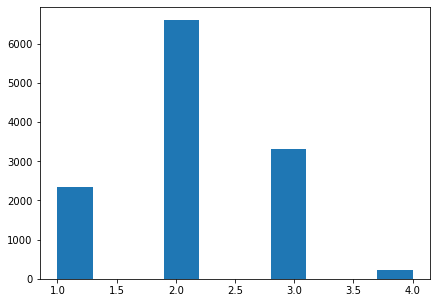

In [19]:
fig, ax = plt.subplots(figsize=(7, 5))
ax.hist(train_labels, align='mid',)
plt.show()

### Outlier Detection

Since the classes are so imbalanced, we could treat this like an outlier detection problem and only try to detect avalanche danger level 4's.

In [20]:
train_labels[train_labels.values == 1] = 0
train_labels[train_labels.values == 2] = 0
train_labels[train_labels.values == 3] = 0
train_labels[train_labels.values == 4] = 1

print(np.unique(train_labels.values))

[0 1]


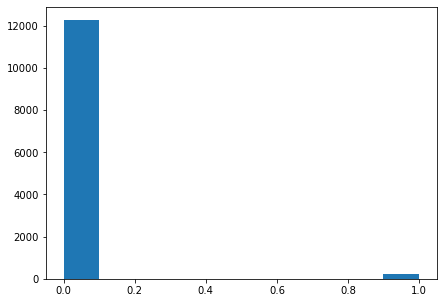

In [21]:
fig, ax = plt.subplots(figsize=(7, 5))
ax.hist(train_labels.values, align='mid',)
plt.show()

In [22]:
class_occurrences = (train_labels.value_counts() / len(train_labels) * 100).sort_index()
round(class_occurrences, 2)

CLASS_danger_level
0                     98.11
1                      1.89
dtype: float64

Scikit-learn makes it easy to calculate class weights for imbalanced classification tasks. Note: this can act as another form of regularization for the model.

In [23]:
flat_values = [value[0] for value in train_labels.values]
weights = class_weight.compute_class_weight('balanced',
                                            np.unique(flat_values),
                                            flat_values)

print(weights)

[ 0.50964827 26.41139241]


These weights are a little different from those given by Scikit-Learn, but I have found them to work better.

In [24]:
weights = {
    0: 5,
    1: 23
}

weights

{0: 5, 1: 23}

Lastly, we can include the danger level in the input data. When we batch and window the data, this means that we can use danger level from the past week to predict tomorrow's danger level.

In [25]:
train['danger_level'] = train_labels
train

,,danger_level_1,danger_level_2,danger_level_3,danger_level_4,danger_level_5,danger_level_6,emergency_warning_1,emergency_warning_2,emergency_warning_3,emergency_warning_4,...,wind_speed_max_0,wind_speed_max_1,wind_speed_max_2,wind_speed_max_3,wind_speed_max_4,wind_speed_max_5,wind_speed_72hr,precip_72hr,temp_max_72hr,danger_level
region,date,,,,,,,,,,,,,,,,,,,,,
3003,2017-12-07,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,1.0,1.0,1.0,...,0.516667,0.300000,0.300000,0.000000,0.300000,0.300000,0.403614,0.006545,0.371942,0
3007,2017-12-07,0.666667,0.333333,0.666667,0.333333,0.333333,0.333333,1.0,1.0,1.0,1.0,...,0.400000,0.300000,0.183333,0.300000,0.300000,0.400000,0.319277,0.049744,0.418220,0
3009,2017-12-07,0.666667,0.333333,0.333333,0.333333,0.333333,0.333333,1.0,1.0,1.0,1.0,...,0.516667,0.183333,0.300000,0.300000,0.300000,0.300000,0.361446,0.102760,0.404998,0
3010,2017-12-07,0.666667,0.666667,0.666667,0.333333,0.333333,0.333333,1.0,1.0,1.0,1.0,...,0.516667,0.183333,0.400000,0.400000,0.300000,0.300000,0.397590,0.140722,0.411609,0
3011,2017-12-07,0.666667,0.666667,0.666667,0.333333,0.333333,0.333333,1.0,1.0,1.0,1.0,...,0.400000,0.183333,0.183333,0.300000,0.300000,0.300000,0.277108,0.157740,0.504165,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3031,2021-01-12,0.666667,0.666667,0.666667,0.333333,0.333333,0.333333,1.0,1.0,1.0,1.0,...,0.300000,0.183333,0.183333,0.516667,0.000000,0.000000,0.240964,0.098178,0.438054,0
3032,2021-01-12,0.666667,0.666667,0.666667,0.333333,0.333333,0.333333,1.0,1.0,1.0,1.0,...,0.400000,0.183333,0.300000,0.400000,0.000000,0.000000,0.319277,0.019636,0.349905,0
3034,2021-01-12,0.666667,0.666667,0.666667,0.333333,0.333333,0.333333,1.0,1.0,1.0,1.0,...,0.300000,0.183333,0.300000,0.400000,0.183333,0.183333,0.283133,0.104724,0.393979,0


# Split data

In [26]:
X_train = [train.loc[idx].values for idx in train_idx]
y_train = [train_labels.loc[idx].values for idx in train_idx]

X_val = [train.loc[idx].values for idx in val_idx]
y_val = [train_labels.loc[idx].values for idx in val_idx]

X_test = [train.loc[idx].values for idx in test_idx]
y_test = [train_labels.loc[idx].values for idx in test_idx]

In [27]:
sequence_length = 7 # this is an arbitrary choice, a hyperparameter
X_train_pad = [pad_sequence(arr, sequence_length) for arr in X_train]
y_train_pad = [pad_sequence(arr, sequence_length) for arr in y_train]

X_val_pad = [pad_sequence(arr, sequence_length) for arr in X_val]
y_val_pad = [pad_sequence(arr, sequence_length) for arr in y_val]

X_test_pad = [pad_sequence(arr, sequence_length) for arr in X_test]
y_test_pad = [pad_sequence(arr, sequence_length) for arr in y_test]

In [28]:
# reshape data into (samples, timesteps, features)
X_concat_train = np.concatenate(X_train_pad)
y_concat_train = np.concatenate(y_train_pad)

X_concat_val = np.concatenate(X_val_pad)
y_concat_val = np.concatenate(y_val_pad)

X_concat_test = np.concatenate(X_test_pad)
y_concat_test = np.concatenate(y_test_pad)

print(X_concat_train.shape)
print(y_concat_train.shape)
print(X_concat_val.shape)
print(y_concat_val.shape)
print(X_concat_test.shape)
print(y_concat_test.shape)

(8939, 1336)
(8939, 1)
(1722, 1336)
(1722, 1)
(1302, 1336)
(1302, 1)


In order to use the recall metric, you need to have your vector of binary values one-hot encoded as a 2D matrix. We can do that below.

In [29]:
encoder = OneHotEncoder()
y_concat_train = encoder.fit_transform(y_concat_train).toarray()
y_concat_val = encoder.fit_transform(y_concat_val).toarray()
y_concat_test = encoder.fit_transform(y_concat_test).toarray()

In [30]:
batchX_train, batchY_train = batch_data(X_concat_train, y_concat_train, sequence_length)
batchX_val, batchY_val = batch_data(X_concat_val, y_concat_val, sequence_length)
batchX_test, batchY_test = batch_data(X_concat_test, y_concat_test, sequence_length)

(8932, 7, 1336) (8932, 2)
(1715, 7, 1336) (1715, 2)
(1295, 7, 1336) (1295, 2)


# Training a neural network

## DNN
We can define our neural network below. This is a multiclass classification problem, meaning that we need as many output units in the last layer as there are unique labels in our training set. It also means that we should use a softmax activation in the last layer and some form of categorical crossentropy as the loss function.

In [31]:
# network params
input_neurons = 60
output_neurons = len(np.unique(y_concat_train))
drop = 0.3

# training params
num_epochs = 8000
alpha = 3e-6
batch_size = 128
criterion = tf.keras.losses.BinaryCrossentropy()
optimizer = tf.keras.optimizers.Adam(lr=alpha)

In [32]:
window_dnn = create_dnn_deep(batchX_train, input_neurons, 6, drop, output_neurons)

window_dnn_history = train_binary(window_dnn, batchX_train, batchY_train, 
                           batchX_val, batchY_val, criterion, optimizer, 
                           batch_size, num_epochs, weights)

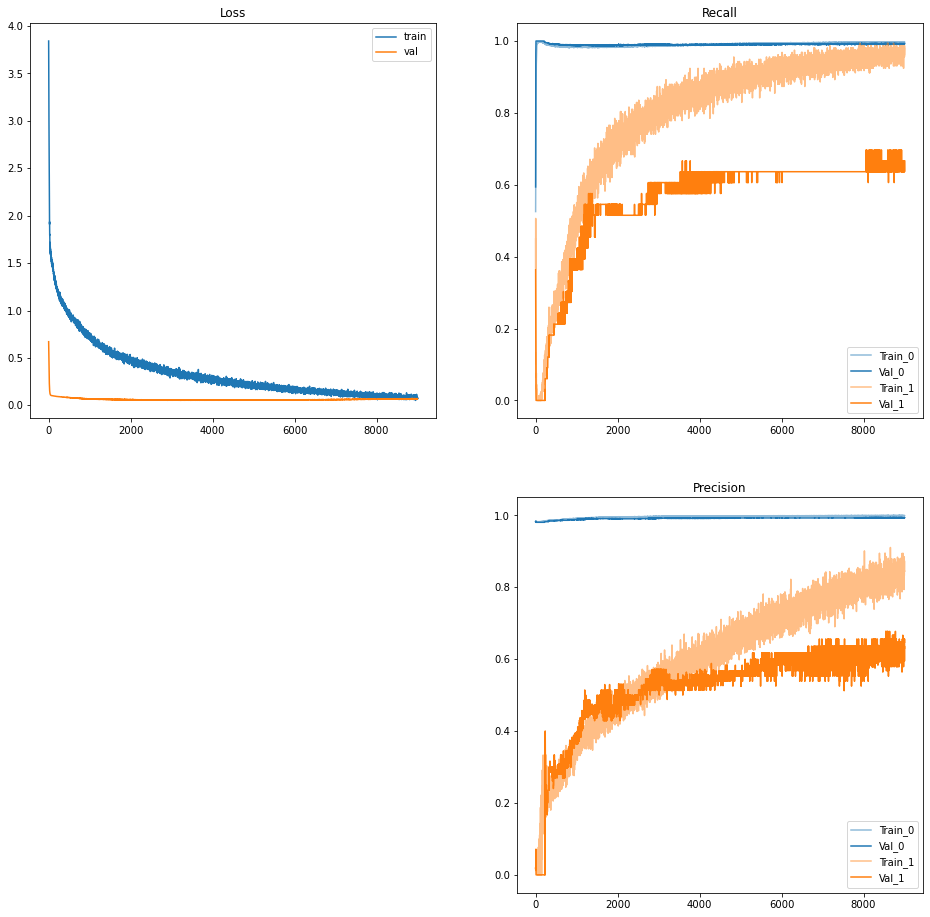

In [33]:
plot_history(window_dnn_history.history)

precision: [0.99345628 0.64705882]
recall:    [0.99286564 0.66666667]
fscore:    [0.99316087 0.65671642]


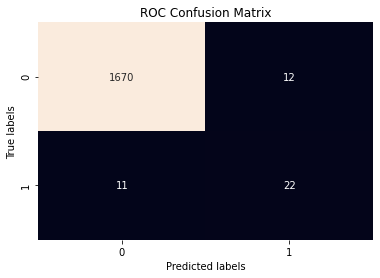

In [34]:
val_preds = plot_confusion_matrix(window_dnn, batchX_val, np.argmax(batchY_val, axis=1))

This doesn't look too bad, actually. And now with regularization?

We could run the following code:
```python
window_dnn_reg = create_dnn_deep(batchX_train, input_neurons, 6, drop, output_neurons, True)

window_dnn_reg_history = train_binary(window_dnn_reg, batchX_train, batchY_train, 
                               batchX_val, batchY_val, criterion, optimizer, 
                               batch_size, num_epochs, weights)

plot_history(window_dnn_reg_history.history)

val_preds = plot_confusion_matrix(window_dnn_reg, batchX_val, np.argmax(batchY_val, axis=1))
```

But in most cases there is only a slight difference in performance, and in the case of the DNN the performance is often worse. Plus, this this training loop takes a long time.

## LSTM

We can repeat the same steps as above, but this time with a LSTM to see how that affects performance.

In [35]:
# network params
input_neurons = 4
dense_neurons = 10
drop = 0.3

# training params
num_epochs = 6000
alpha = 1e-6
batch_size = 256

In [37]:
window_rnn = create_rnn(batchX_train, input_neurons, dense_neurons, drop, output_neurons)

window_rnn_history = train_binary(window_rnn, batchX_train, batchY_train, 
                           batchX_val, batchY_val, criterion, optimizer, 
                           batch_size, num_epochs, weights)

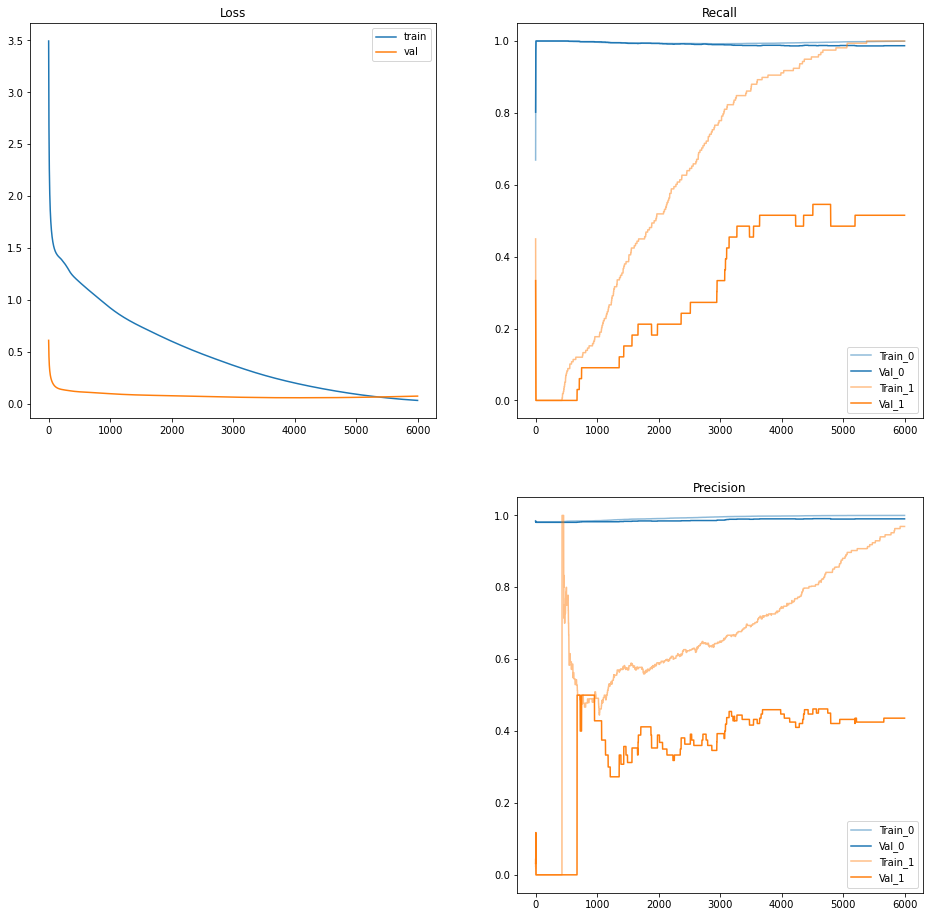

In [38]:
plot_history(window_rnn_history.history)

precision: [0.99045346 0.43589744]
recall:    [0.98692033 0.51515152]
fscore:    [0.98868374 0.47222222]


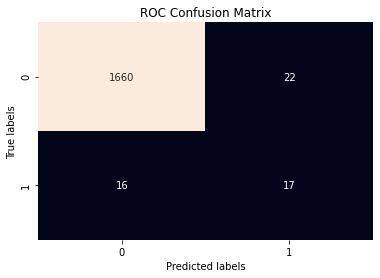

In [39]:
val_preds = plot_confusion_matrix(window_rnn, batchX_val, np.argmax(batchY_val, axis=1))

Not great. Again, we could run the same code to figure out how regularization would affect performance.
```python
window_rnn_reg = create_rnn(batchX_train, input_neurons, dense_neurons, drop, output_neurons, True)

window_rnn_reg_history = train_binary(window_rnn_reg, batchX_train, batchY_train, 
                               batchX_val, batchY_val, criterion, optimizer, 
                               batch_size, num_epochs, weights)

plot_history(window_rnn_reg_history.history)

val_preds = plot_confusion_matrix(window_rnn_reg, batchX_val, np.argmax(batchY_val, axis=1))
```

# Predicting on the test set

This is relatively easy to set up. Since we have already processed the test set alongside the training and validation sets, it should be ready to go.

We should save the best models so that we can load them later (instead of running the whole Notebook again). Note: we only need to save the models once unless we decide to retrain the them later.

In [43]:
# save best model
# https://www.tensorflow.org/tutorials/keras/save_and_load?hl=en
best_dnn = window_dnn
best_rnn = window_rnn

best_dnn.save('models/dnn_dl_4')
best_rnn.save('models/rnn_dl_4')

INFO:tensorflow:Assets written to: models/dnn_dl_4/assets
INFO:tensorflow:Assets written to: models/rnn_dl_4/assets


precision: [0.97793538 0.61538462]
recall:    [0.99200639 0.36363636]
fscore:    [0.98492063 0.45714286]


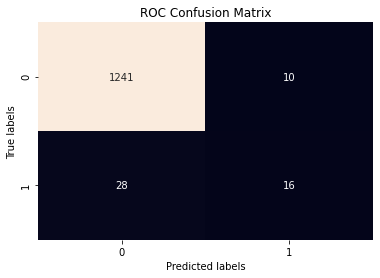

In [44]:
# load saved model
best_dnn = tf.keras.models.load_model('models/dnn_dl_4')
test_preds = plot_confusion_matrix(best_dnn, batchX_test, np.argmax(batchY_test, axis=1))

precision: [0.97639654 0.58333333]
recall:    [0.99200639 0.31818182]
fscore:    [0.98413957 0.41176471]


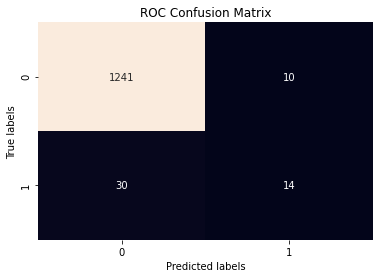

In [45]:
best_rnn = tf.keras.models.load_model('models/rnn_dl_4')
test_preds = plot_confusion_matrix(best_rnn, batchX_test, np.argmax(batchY_test, axis=1))